# Combined Kriging Class

In [8]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import scipy.stats
from scipy import spatial
from scipy import optimize
from scipy import special
import time
from scipy.spatial.distance import cdist

In [39]:
class Kriging(object):
    # What do I want: 
    # passing: Data with properties, layer, geo_data --> meaning that I have to cut everything in here!
    # possibility to read in data - check gempy how to do best
    # analyzing data part needs to be in here somewhere, have to check how "OK" that is,
    # and if I can switch between covariance function (SK) and variogram function (OK, UK) in a reasonable manner
    # Selection:
    # SK, OK, UK
    # cdist or my distance
    # SGS or not?
    def __init__(self, property_data, geomodel, grid, formation_number):
        # here I want to put the basic variables and also the data analysis - or maybe even everything?!
        #if '' in kwds:
        #    self.set_nxny(kwds['nx'], kwds['ny'])
        
        self.geomodel = geomodel
        self.grid = grid
        self.formation_number = formation_number
        
        #PART 1: Initializing data and domain
        # set domain data
        self.grid_dataframe = self.init_domain()
        # set property data (finally needs to be an 2d array with index in grid_dataframe and value)
        self.property_data = property_data # preset for now
        
        #PART 2: Analyzing the data - mainly getting a variogram/covariance function 
        # best case, only do that if not done before, so only of nothing is specified in keywords
        self.model = 'gaussian' # everything preset for now
        self.range_ = 170
        self.sill = 40
        self.nugget = 10
        
        
        #PART 3: Acutally performing Kriging 
        self.kriging_result = self.sgs() 
        
            
        # get data - save it and tie it to corresponding grid points
    
    #def get_data():
        # method to read data from given csv and create pandas dataframe
        
    def init_domain (self):
        """
        Method to create a new pandas dataframe containing a grid for the SGS. Grid from complete geologic model is
        reduced to a certain formation of interest. Thus as of now, Kriging is only possible within one layer of the
        model. Allowing multiple layers or the whole model should not be too difficult if required.
        Args:
            geomodel (numpy.ndarray): lithological block model created with gempy
            grid (gempy.data_management.GridClass): Grid created for geologic model
            formation_number (int): Number of formation to perform CoKriging on
        Returns:
            pandas.dataframe: Dataframe with all relevant data for grid, meaning xyz of each grid point.
        """
    
        # convert lith block values to int, thats what Miguel suggested --> maybe a better solution required
        geomodel_int = np.round(self.geomodel[0])
    
        # create the dataframe and populate with data
        d = {'X': self.grid.values[:,0], 'Y': self.grid.values[:,1], 'Z': self.grid.values[:,2], 'lith': geomodel_int}
        dataframe_aux = pd.DataFrame(data=d)

        # cut down to wanted lithology and reset dataframne
        grid_dataframe = dataframe_aux.loc[dataframe_aux['lith'] == self.formation_number]
        grid_dataframe = grid_dataframe.reset_index() # reset indicies
        del grid_dataframe['index'] # reset indices

        return grid_dataframe
    
    #def analyse_data():
        # method for getting mean, std, etc. of the given dataset
        
    def precalculate_distances(self, prop_data, sgs_check, grid_coord):
    
        # order grid by indices given in prop_data[0] and sgs check
        aux = np.append(prop_data[0], sgs_check)
        grid_reordered = grid_coord[aux]

        # perform cdist
        dist_matrix = cdist(grid_reordered, grid_reordered)

        return dist_matrix
    
    def gaussian_variogram_model(self, d):
        psill =self.sill-self.nugget
        gamma = psill * (1. - np.exp(-d**2./(self.range_)**2.))+self.nugget
        return gamma

    def ordinary_kriging(self, target_point, a, b, prop):
        #def ordinary_kriging(point, data):

        # empty matrix building
        shape = len(a)
        C = np.zeros((shape+1, shape+1))
        c = np.zeros((shape+1))
        w = np.zeros((shape+1))

        # Faster matrix building approach, no loops
        C[:shape, :shape] = self.gaussian_variogram_model(b)
        c[:shape] = self.gaussian_variogram_model(a)

        # matrix setup - compare pykrige, special for OK
        np.fill_diagonal(C, 0)
        C[shape, :] = 1.0
        C[:, shape] = 1.0
        C[shape, shape] = 0.0  
        c[shape] = 1.0

        # Solve Kriging equations
        w = np.linalg.solve(C,c)

        # SGS version - need to get mean and std
        #result = np.random.normal(np.sum(w[:shape] * prop), scale=np.sqrt(w[shape]-gaussian_variogram_model(0)+np.sum(w[:shape]*c[:shape])))

        # direct version, calculating result from weights.
        result = np.sum(w[:shape] * prop)

        return result
    
    def get_distance_matrices(self, dist_matrix, n, prop_data):
        """
        Method to get closest points out of distance matrix calculated beforehand.
        Args:
            dist_matrix (np.array): matrix of distances between existing property data points
            n(int): number of closest points used 
            prop_data(np.array)(n,2): array containing indexes of property data in grid and corresponding values
        Returns
            dist_close_all_to_all: 
            dist_close_target_to_all:
        """
        #index of target point
        target_point = len(dist_matrix)-1

        # check for n closest points in matrix (minimum distance values) and sort the resulting index array
        ind = np.argpartition(dist_matrix[target_point], n+1)[:n+1]
        sort_ind = np.sort(ind)

        # create new property array to match property data to correct indices
        ind_aux_prop = sort_ind[:len(sort_ind)-1]
        closest_prop_data = prop_data[1][ind_aux_prop]

        # extract distances from target point (row of target index - now last row of matrix) without last entry (target)
        dist_close_target_to_all = dist_matrix[target_point][sort_ind]
        dist_close_target_to_all = dist_close_target_to_all[:len(dist_close_target_to_all)-1]

        # extract distance each to each for those closest points, delete target point index row and column
        dist_close_all_to_all = dist_matrix[np.ix_(sort_ind[:len(sort_ind)-1],sort_ind[:len(sort_ind)-1])]

        return dist_close_target_to_all, dist_close_all_to_all, closest_prop_data

    def sgs(self):
        
        grid_coord = self.grid_dataframe.values
        #grid_coord = np.delete(coord3d, 3, 1) # only required if there still is a lith column at the end
        print(len(grid_coord))
        
        prop_data = self.property_data
    
        # just for progress bar
        runs = len(grid_coord)-len(prop_data[0])

        # for timing purposes
        time_prec = 0
        time_sub = 0
        time_dist = 0
        time_krig = 0

        # create array to go through SGS, only containing indices of grid points without data
        sgs_check = np.arange(0,len(grid_coord))
        sgs_check = np.delete(sgs_check, prop_data[0])

        # randomize it to predefine SGS way
        np.random.shuffle(sgs_check)

        # precalculate distances
        t_pre1 = time.time()
        dist_matrix_sgs_order = self.precalculate_distances(prop_data, sgs_check, grid_coord)
        t_pre2 = time.time()
        print("distance precalculation:", t_pre2-t_pre1)

        # set initial length of property data frame
        start = len(prop_data[0])

        for i in range(0, len(sgs_check)):

            # choose first point from sgs_check, as this is already randomized
            target_point = sgs_check[i]

            t0 = time.time()
            # extract submatrix required for distances
            submatrix = dist_matrix_sgs_order[0:start+i+1,0:start+i+1] 

            t1 = time.time()
            time_sub = time_sub+(t1-t0)
            # get closest distances
            a, b, prop = self.get_distance_matrices(submatrix, 4, prop_data)

            t2 = time.time()
            time_dist = time_dist+(t2-t1)
            # perform the Kriging interpolation on this point
            kriging_result = self.ordinary_kriging(target_point, a , b, prop) 

            t3 = time.time()
            time_krig = time_krig+(t3-t2)

            # add point to property data list
            prop_data = np.hstack((prop_data, ([[target_point], [kriging_result]])))
            prop_data = np.round(prop_data) # just for now

            #use of progress bar ...
            #updt(runs,i+1)

        # sort the results properly at the end - needs to be optimized for not rounding it 
        prop_data = np.round(prop_data) # just for now
        prop_data = sorted(np.swapaxes(prop_data,0,1), key=lambda row: row[0])
        prop_data = np.vstack(prop_data)
        prop_data = np.swapaxes(prop_data,0,1)

        print("submatrix extraction:", time_sub)
        print("distance Matrices:", time_dist)
        print("kriging calculation:", time_krig)

        return prop_data

In [21]:
# more complex test run with the data I used before
domain = pd.read_csv("domain3d.csv")
data = pd.read_csv("data3d.csv")
variogram_fit = pd.read_csv("variogram_fit.csv")
prop_coord = data.as_matrix(('X','Y','Z'))
coord3d = domain.values
coord3d = np.delete(coord3d, 3, 1)

# workaround to match data position to grid
coord3d_round = np.round(coord3d, 2) 
prop_coord_round = np.round(prop_coord, 2)

# finding positions of prop_data in grid
prop_d = np.zeros(len(prop_coord))

for i in range (len(prop_coord)):
    prop_d[i] = np.argwhere(np.all(coord3d_round == prop_coord_round[i], axis=1))[0][0]
    
values = data.as_matrix(('Property',))
prop_d = prop_d.reshape((200,1))

data_pos = np.hstack((prop_d, values))
data_pos = data_pos.transpose()
data_pos = data_pos.astype(int)

C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [4]:
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_interfaces") # importing point-positional interface data

C:\Users\Jan\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [6]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [40]:
test = Kriging(data_pos, lith_block, geo_data.grid, formation_number=3)

3756
distance precalculation: 0.1562364101409912
submatrix extraction: 0.0
distance Matrices: 0.14060401916503906
kriging calculation: 0.2187659740447998


In [41]:
test.kriging_result.shape
coord3d_aux = test.grid_dataframe.values
coord3d_aux = np.delete(coord3d_aux, 3, 1)
coord3d_aux = np.swapaxes(coord3d_aux, 0,1) # for plotting later

In [42]:
import matplotlib as mpl

# define the colormap
cmap = plt.cm.PuBu_r
# extract all colors
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,40,8)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

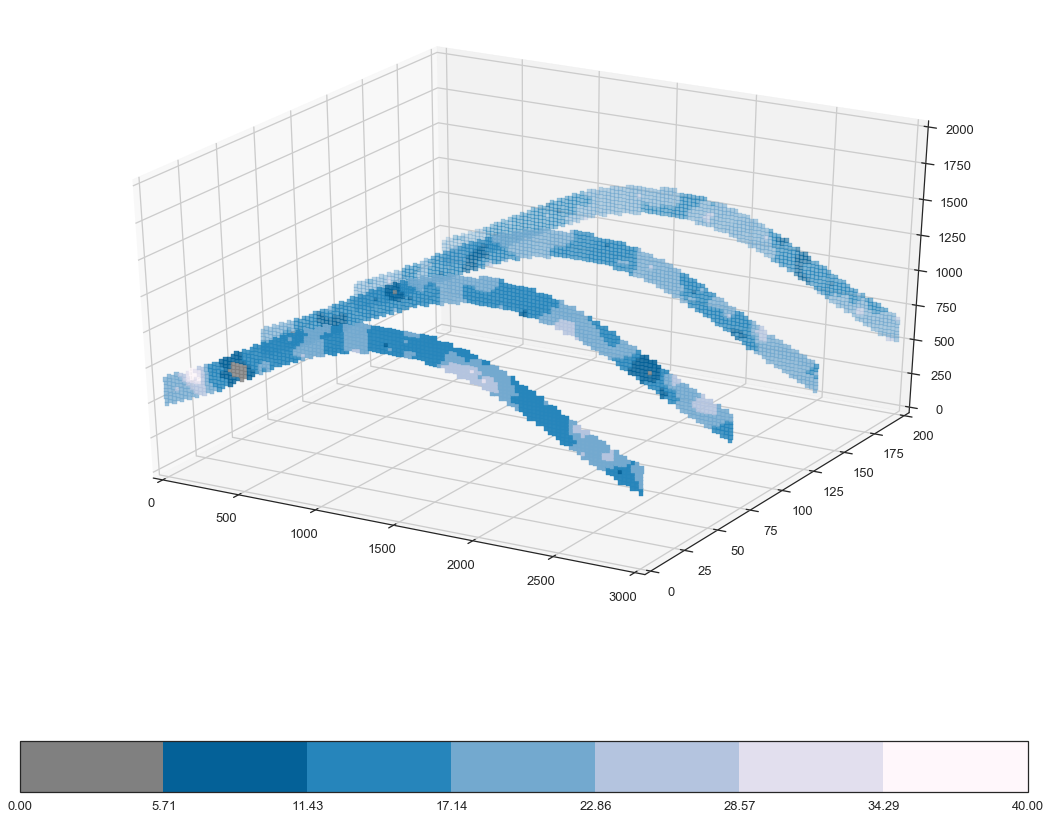

In [43]:
fig = plt.figure(figsize=(14, 12))
ax = Axes3D(fig)

ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
a = ax.scatter3D(xs=coord3d_aux[0],ys=coord3d_aux[1],zs=coord3d_aux[2], c=test.kriging_result[1], s=20, marker=',', cmap=cmap, norm=norm)
# b = ax.scatter3D(xs=data.X,ys=data.Y,zs=data.Z, c=data.Property, s=50, marker='o', cmap=cmap, norm=norm, linewidths=1, edgecolors='black')

fig.colorbar(a, orientation='horizontal')